# Malaysian Rental Pricing Prediction

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# Data Preprocessing

## Loading the dataset

Now, let's load the dataset and display the first few rows of the dataset.

In [4]:
# Constant for random state seed
RANDOM_STATE_SEED = 1

# Load the dataset
data_path = './data/mudah-apartment-kl-selangor.csv'
df = pd.read_csv(data_path)

# Display the first few rows of the dataset
df.head()

,ads_id,prop_name,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,facilities,additional_facilities,region
0,100323185,The Hipster @ Taman Desa,2022.0,RM 4 200 per month,Kuala Lumpur - Taman Desa,Condominium,5,2.0,6.0,1842 sq.ft.,Fully Furnished,"Minimart, Gymnasium, Security, Playground, Swi...","Air-Cond, Cooking Allowed, Washing Machine",Kuala Lumpur
1,100203973,Segar Courts,NaN,RM 2 300 per month,Kuala Lumpur - Cheras,Condominium,3,1.0,2.0,1170 sq.ft.,Partially Furnished,"Playground, Parking, Barbeque area, Security, ...","Air-Cond, Cooking Allowed, Near KTM/LRT",Kuala Lumpur
2,100323128,Pangsapuri Teratak Muhibbah 2,NaN,RM 1 000 per month,Kuala Lumpur - Taman Desa,Apartment,3,NaN,2.0,650 sq.ft.,Fully Furnished,"Minimart, Jogging Track, Lift, Swimming Pool",NaN,Kuala Lumpur
3,100191767,Sentul Point Suite Apartment,2020.0,RM 1 700 per month,Kuala Lumpur - Sentul,Apartment,2,1.0,2.0,743 sq.ft.,Partially Furnished,"Parking, Playground, Swimming Pool, Squash Cou...","Cooking Allowed, Near KTM/LRT, Washing Machine",Kuala Lumpur
4,97022692,Arte Mont Kiara,NaN,RM 1 299 per month,Kuala Lumpur - Mont Kiara,Service Residence,1,1.0,1.0,494 sq.ft.,Not Furnished,"Parking, Security, Lift, Swimming Pool, Playgr...",Air-Cond,Kuala Lumpur


In [5]:
# Check the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19991 entries, 0 to 19990
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ads_id                 19991 non-null  int64  
 1   prop_name              19043 non-null  object 
 2   completion_year        10806 non-null  float64
 3   monthly_rent           19989 non-null  object 
 4   location               19991 non-null  object 
 5   property_type          19991 non-null  object 
 6   rooms                  19985 non-null  object 
 7   parking                14289 non-null  float64
 8   bathroom               19985 non-null  float64
 9   size                   19991 non-null  object 
 10  furnished              19986 non-null  object 
 11  facilities             17782 non-null  object 
 12  additional_facilities  14043 non-null  object 
 13  region                 19991 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 2.1+

In [6]:
# Check for outliers
df.describe()

,ads_id,completion_year,parking,bathroom
count,1.999100e+04,10806.000000,14289.000000,19985.000000
mean,9.970671e+07,2014.822321,1.416824,1.891719
std,3.482575e+06,6.735355,0.567368,0.556266
min,1.652551e+07,1977.000000,1.000000,1.000000
25%,9.984012e+07,2012.000000,1.000000,2.000000
50%,1.002127e+08,2017.000000,1.000000,2.000000
75%,1.006179e+08,2020.000000,2.000000,2.000000
max,1.008546e+08,2025.000000,10.000000,8.000000


In [7]:
# Check column null data
df.isnull().sum()

ads_id                      0
prop_name                 948
completion_year          9185
monthly_rent                2
location                    0
property_type               0
rooms                       6
parking                  5702
bathroom                    6
size                        0
furnished                   5
facilities               2209
additional_facilities    5948
region                      0
dtype: int64

From the above info, we can list out the task we need to do:

1. Columns `monthly_rent`, `size` to be converted to type `int`
2. Drop `ads_id` and `prop_name` since they don't help in price prediction
3. Dealing with null values:
    * `completion_year` to use median / mean imputation
    * drop rows where `monthly_rent` is null
    * `rooms` to explore, minimum 1 else it shouldn't be listed
    * `parking` to fill null with 0
    * `bathroom` and `furnished` to be explored
    * `facilities` and `additional_facilities` both be dropped since there are too many null values
4. Dealing with outliers
    * Remove rows where `completion_year` is 2025
    * Remove further outliers


## Drop columns and rows

In [8]:
# Drop unused columns
df = df.drop(['ads_id', 'prop_name', 'facilities', 'additional_facilities'], axis=1)
df = df.dropna(subset=['monthly_rent'], axis=0)
df.head(10)

,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,region
0,2022.0,RM 4 200 per month,Kuala Lumpur - Taman Desa,Condominium,5,2.0,6.0,1842 sq.ft.,Fully Furnished,Kuala Lumpur
1,NaN,RM 2 300 per month,Kuala Lumpur - Cheras,Condominium,3,1.0,2.0,1170 sq.ft.,Partially Furnished,Kuala Lumpur
2,NaN,RM 1 000 per month,Kuala Lumpur - Taman Desa,Apartment,3,NaN,2.0,650 sq.ft.,Fully Furnished,Kuala Lumpur
3,2020.0,RM 1 700 per month,Kuala Lumpur - Sentul,Apartment,2,1.0,2.0,743 sq.ft.,Partially Furnished,Kuala Lumpur
4,NaN,RM 1 299 per month,Kuala Lumpur - Mont Kiara,Service Residence,1,1.0,1.0,494 sq.ft.,Not Furnished,Kuala Lumpur
5,NaN,RM 1 500 per month,Kuala Lumpur - Setapak,Apartment,3,1.0,2.0,884 sq.ft.,Partially Furnished,Kuala Lumpur
6,NaN,RM 2 900 per month,Kuala Lumpur - Sentul,Service Residence,3,2.0,2.0,982 sq.ft.,Fully Furnished,Kuala Lumpur
7,2018.0,RM 1 550 per month,Kuala Lumpur - Ampang,Service Residence,1,1.0,1.0,700 sq.ft.,Fully Furnished,Kuala Lumpur
8,2014.0,RM 1 400 per month,Kuala Lumpur - Segambut,Apartment,2,1.0,1.0,750 sq.ft.,Fully Furnished,Kuala Lumpur
9,NaN,RM 1 350 per month,Kuala Lumpur - Desa ParkCity,Condominium,3,1.0,2.0,862 sq.ft.,Partially Furnished,Kuala Lumpur


## Datatype Conversion

In [9]:
# Columns monthly_rent, size to be converted to type int
df['monthly_rent'] = df['monthly_rent'].str.replace(' ', '').str.extract(r'(\d+\s*\d*)').astype(int)
df['size'] = df['size'].str.replace(' ', '').str.extract(r'(\d+\s*\d*)').astype(int)
df.head()

,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,region
0,2022.0,4200,Kuala Lumpur - Taman Desa,Condominium,5,2.0,6.0,1842,Fully Furnished,Kuala Lumpur
1,NaN,2300,Kuala Lumpur - Cheras,Condominium,3,1.0,2.0,1170,Partially Furnished,Kuala Lumpur
2,NaN,1000,Kuala Lumpur - Taman Desa,Apartment,3,NaN,2.0,650,Fully Furnished,Kuala Lumpur
3,2020.0,1700,Kuala Lumpur - Sentul,Apartment,2,1.0,2.0,743,Partially Furnished,Kuala Lumpur
4,NaN,1299,Kuala Lumpur - Mont Kiara,Service Residence,1,1.0,1.0,494,Not Furnished,Kuala Lumpur


## Null Imputation

### `completion_year` to use median / mean imputation

<Axes: xlabel='completion_year', ylabel='Count'>

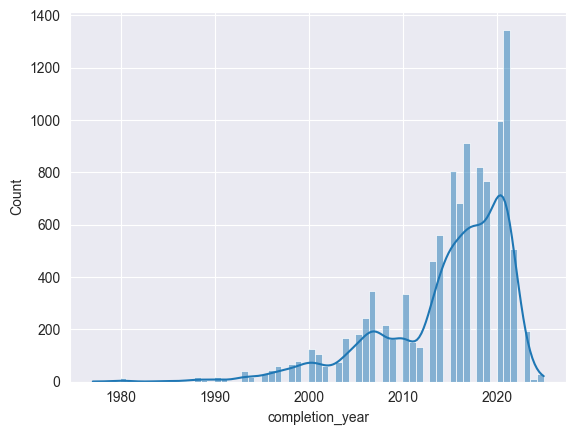

In [10]:
# Check distributions in the column
sns.histplot(df['completion_year'], kde=True)

In [11]:
# The graph is skewed, use median imputation
df['completion_year'] = df['completion_year'].fillna(df['completion_year'].median()).astype(int)
df.head()

,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,region
0,2022,4200,Kuala Lumpur - Taman Desa,Condominium,5,2.0,6.0,1842,Fully Furnished,Kuala Lumpur
1,2017,2300,Kuala Lumpur - Cheras,Condominium,3,1.0,2.0,1170,Partially Furnished,Kuala Lumpur
2,2017,1000,Kuala Lumpur - Taman Desa,Apartment,3,NaN,2.0,650,Fully Furnished,Kuala Lumpur
3,2020,1700,Kuala Lumpur - Sentul,Apartment,2,1.0,2.0,743,Partially Furnished,Kuala Lumpur
4,2017,1299,Kuala Lumpur - Mont Kiara,Service Residence,1,1.0,1.0,494,Not Furnished,Kuala Lumpur


### `rooms` to explore, minimum 1 else it shouldn't be listed

In [12]:
# View rowswhere 'rooms' is null
df[df['rooms'].isnull()]

,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,region
3668,2017,150,Kuala Lumpur - Sentul,Condo / Services residence / Penthouse / Townh...,NaN,NaN,NaN,100,Not Furnished,Kuala Lumpur
8112,2017,100,Kuala Lumpur - Mid Valley City,Residential,NaN,NaN,NaN,100,NaN,Kuala Lumpur
12875,2017,650,Selangor - 43,Houses,NaN,1.0,NaN,300,Fully Furnished,Selangor
15765,2017,85,Selangor - Seri Kembangan,Soho,NaN,1.0,NaN,761,NaN,Selangor
16812,2017,600,Selangor - Kajang,Others,NaN,NaN,NaN,750,NaN,Selangor
16991,2017,150,Selangor - Sungai Buloh,Others,NaN,NaN,NaN,25,Not Furnished,Selangor


As a Malaysian, since the rental is quite low thus we can assume that `rooms` is 1.

Also, since these rows are the ones where `bathroom` is also null, thus we assume that this 1 room will have 0 bathroom.

In [13]:
df.loc[df['rooms'].isnull(), ['rooms', 'bathroom']] = [1, 0]
df.head()

,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,region
0,2022,4200,Kuala Lumpur - Taman Desa,Condominium,5,2.0,6.0,1842,Fully Furnished,Kuala Lumpur
1,2017,2300,Kuala Lumpur - Cheras,Condominium,3,1.0,2.0,1170,Partially Furnished,Kuala Lumpur
2,2017,1000,Kuala Lumpur - Taman Desa,Apartment,3,NaN,2.0,650,Fully Furnished,Kuala Lumpur
3,2020,1700,Kuala Lumpur - Sentul,Apartment,2,1.0,2.0,743,Partially Furnished,Kuala Lumpur
4,2017,1299,Kuala Lumpur - Mont Kiara,Service Residence,1,1.0,1.0,494,Not Furnished,Kuala Lumpur


### `parking` to fill null with 0

In [14]:
df.loc[df['parking'].isnull(), 'parking'] = 0
df.head()

,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,region
0,2022,4200,Kuala Lumpur - Taman Desa,Condominium,5,2.0,6.0,1842,Fully Furnished,Kuala Lumpur
1,2017,2300,Kuala Lumpur - Cheras,Condominium,3,1.0,2.0,1170,Partially Furnished,Kuala Lumpur
2,2017,1000,Kuala Lumpur - Taman Desa,Apartment,3,0.0,2.0,650,Fully Furnished,Kuala Lumpur
3,2020,1700,Kuala Lumpur - Sentul,Apartment,2,1.0,2.0,743,Partially Furnished,Kuala Lumpur
4,2017,1299,Kuala Lumpur - Mont Kiara,Service Residence,1,1.0,1.0,494,Not Furnished,Kuala Lumpur


In [15]:
# Check if can safely convert to integer type

for col in ['rooms', 'parking', 'bathroom']:
    print(df[col].value_counts())

rooms
3.0             6459
3               6320
2               1805
1.0             1527
2.0             1489
4                915
1                867
4.0              473
5                 54
5.0               38
6                 19
1                  6
7                  6
6.0                4
More than 10       2
7.0                2
9                  1
9.0                1
10.0               1
Name: count, dtype: int64
parking
1.0     8644
0.0     5701
2.0     5426
3.0      179
4.0       23
10.0       6
5.0        6
6.0        2
9.0        1
7.0        1
Name: count, dtype: int64
bathroom
2.0    14885
1.0     3800
3.0     1065
4.0      160
5.0       54
6.0        9
7.0        7
0.0        6
8.0        3
Name: count, dtype: int64


In [16]:
# Use 11 to represent 'More than 10'
df.loc[df['rooms'] == 'More than 10', 'rooms'] = 11
df

,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,region
0,2022,4200,Kuala Lumpur - Taman Desa,Condominium,5,2.0,6.0,1842,Fully Furnished,Kuala Lumpur
1,2017,2300,Kuala Lumpur - Cheras,Condominium,3,1.0,2.0,1170,Partially Furnished,Kuala Lumpur
2,2017,1000,Kuala Lumpur - Taman Desa,Apartment,3,0.0,2.0,650,Fully Furnished,Kuala Lumpur
3,2020,1700,Kuala Lumpur - Sentul,Apartment,2,1.0,2.0,743,Partially Furnished,Kuala Lumpur
4,2017,1299,Kuala Lumpur - Mont Kiara,Service Residence,1,1.0,1.0,494,Not Furnished,Kuala Lumpur
...,...,...,...,...,...,...,...,...,...,...
19986,2017,1200,Selangor - Kajang,Apartment,3.0,0.0,2.0,1000,Partially Furnished,Selangor
19987,2018,1300,Selangor - Bandar Saujana Putra,Service Residence,4.0,2.0,3.0,1427,Partially Furnished,Selangor
19988,2017,1350,Selangor - Kajang,Condominium,3.0,2.0,2.0,1270,Partially Furnished,Selangor
19989,2017,1200,Selangor - Cyberjaya,Service Residence,3.0,1.0,2.0,1100,Fully Furnished,Selangor


In [17]:
# Convert to int
df['rooms'] = df['rooms'].astype(float).astype(int)
df['parking'] = df['parking'].astype(float).astype(int)
df['bathroom'] = df['bathroom'].astype(float).astype(int)
df.head()

,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,region
0,2022,4200,Kuala Lumpur - Taman Desa,Condominium,5,2,6,1842,Fully Furnished,Kuala Lumpur
1,2017,2300,Kuala Lumpur - Cheras,Condominium,3,1,2,1170,Partially Furnished,Kuala Lumpur
2,2017,1000,Kuala Lumpur - Taman Desa,Apartment,3,0,2,650,Fully Furnished,Kuala Lumpur
3,2020,1700,Kuala Lumpur - Sentul,Apartment,2,1,2,743,Partially Furnished,Kuala Lumpur
4,2017,1299,Kuala Lumpur - Mont Kiara,Service Residence,1,1,1,494,Not Furnished,Kuala Lumpur


### `furnished` to be explored

In [18]:
# Explore 'furnished' column
df['furnished'].value_counts()

furnished
Fully Furnished        8462
Partially Furnished    8004
Not Furnished          3520
Name: count, dtype: int64

In [19]:
# Rows where 'furnished' is null
df[df['furnished'].isnull()]

,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,region
8112,2017,100,Kuala Lumpur - Mid Valley City,Residential,1,0,0,100,NaN,Kuala Lumpur
15765,2017,85,Selangor - Seri Kembangan,Soho,1,1,0,761,NaN,Selangor
16812,2017,600,Selangor - Kajang,Others,1,0,0,750,NaN,Selangor


We explore the typical `monthly_rent` for 1 room for each `furnished` type

In [20]:
df[df['rooms'] == 1]['monthly_rent'].groupby(df['furnished']).mean()

furnished
Fully Furnished        1628.430286
Not Furnished           868.050000
Partially Furnished    3423.601713
Name: monthly_rent, dtype: float64

Okay this looks illogical for partial furnished to be significantly higher than fully furnished, outliers exist so let's use median

In [21]:
df[df['rooms'] == 1]['monthly_rent'].groupby(df['furnished']).median()

furnished
Fully Furnished        1400.0
Not Furnished           800.0
Partially Furnished    1200.0
Name: monthly_rent, dtype: float64

Since all the rooms with `furnished` as null have rental below 800, we just set them to unfurnished

In [22]:
df.loc[df['furnished'].isnull(), 'furnished'] = 'Not Furnished'
df

,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,region
0,2022,4200,Kuala Lumpur - Taman Desa,Condominium,5,2,6,1842,Fully Furnished,Kuala Lumpur
1,2017,2300,Kuala Lumpur - Cheras,Condominium,3,1,2,1170,Partially Furnished,Kuala Lumpur
2,2017,1000,Kuala Lumpur - Taman Desa,Apartment,3,0,2,650,Fully Furnished,Kuala Lumpur
3,2020,1700,Kuala Lumpur - Sentul,Apartment,2,1,2,743,Partially Furnished,Kuala Lumpur
4,2017,1299,Kuala Lumpur - Mont Kiara,Service Residence,1,1,1,494,Not Furnished,Kuala Lumpur
...,...,...,...,...,...,...,...,...,...,...
19986,2017,1200,Selangor - Kajang,Apartment,3,0,2,1000,Partially Furnished,Selangor
19987,2018,1300,Selangor - Bandar Saujana Putra,Service Residence,4,2,3,1427,Partially Furnished,Selangor
19988,2017,1350,Selangor - Kajang,Condominium,3,2,2,1270,Partially Furnished,Selangor
19989,2017,1200,Selangor - Cyberjaya,Service Residence,3,1,2,1100,Fully Furnished,Selangor


In [23]:
# Check if all null is handled
df.isnull().sum()

completion_year    0
monthly_rent       0
location           0
property_type      0
rooms              0
parking            0
bathroom           0
size               0
furnished          0
region             0
dtype: int64

In [24]:
# Remove rows where 'completion_year' is after 2024
df = df[df['completion_year'] <= 2024]
df

,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,region
0,2022,4200,Kuala Lumpur - Taman Desa,Condominium,5,2,6,1842,Fully Furnished,Kuala Lumpur
1,2017,2300,Kuala Lumpur - Cheras,Condominium,3,1,2,1170,Partially Furnished,Kuala Lumpur
2,2017,1000,Kuala Lumpur - Taman Desa,Apartment,3,0,2,650,Fully Furnished,Kuala Lumpur
3,2020,1700,Kuala Lumpur - Sentul,Apartment,2,1,2,743,Partially Furnished,Kuala Lumpur
4,2017,1299,Kuala Lumpur - Mont Kiara,Service Residence,1,1,1,494,Not Furnished,Kuala Lumpur
...,...,...,...,...,...,...,...,...,...,...
19986,2017,1200,Selangor - Kajang,Apartment,3,0,2,1000,Partially Furnished,Selangor
19987,2018,1300,Selangor - Bandar Saujana Putra,Service Residence,4,2,3,1427,Partially Furnished,Selangor
19988,2017,1350,Selangor - Kajang,Condominium,3,2,2,1270,Partially Furnished,Selangor
19989,2017,1200,Selangor - Cyberjaya,Service Residence,3,1,2,1100,Fully Furnished,Selangor


In [25]:
# Check statistics
df.describe()

,completion_year,monthly_rent,rooms,parking,bathroom,size
count,19960.000000,1.996000e+04,19960.000000,19960.000000,19960.000000,1.996000e+04
mean,2015.809419,2.269346e+03,2.680912,1.011874,1.890982,5.929957e+03
std,5.061202,2.242913e+04,0.812706,0.799324,0.557563,7.078086e+05
min,1977.000000,7.000000e+01,1.000000,0.000000,0.000000,1.000000e+00
25%,2016.000000,1.100000e+03,2.000000,0.000000,2.000000,7.500000e+02
50%,2017.000000,1.400000e+03,3.000000,1.000000,2.000000,8.850000e+02
75%,2017.000000,1.800000e+03,3.000000,2.000000,2.000000,1.044000e+03
max,2024.000000,2.400000e+06,11.000000,10.000000,8.000000,1.000000e+08


In [26]:
# Remove outliers for 'monthly_rent', 'rooms', 'parking', 'bathroom' and 'size'
col_to_rm_outliers = ['monthly_rent', 'rooms', 'parking', 'bathroom', 'size']

def remove_outliers(df, col):

    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

for col in col_to_rm_outliers:
    df = remove_outliers(df, col)

df

,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,region
1,2017,2300,Kuala Lumpur - Cheras,Condominium,3,1,2,1170,Partially Furnished,Kuala Lumpur
2,2017,1000,Kuala Lumpur - Taman Desa,Apartment,3,0,2,650,Fully Furnished,Kuala Lumpur
3,2020,1700,Kuala Lumpur - Sentul,Apartment,2,1,2,743,Partially Furnished,Kuala Lumpur
5,2017,1500,Kuala Lumpur - Setapak,Apartment,3,1,2,884,Partially Furnished,Kuala Lumpur
9,2017,1350,Kuala Lumpur - Desa ParkCity,Condominium,3,1,2,862,Partially Furnished,Kuala Lumpur
...,...,...,...,...,...,...,...,...,...,...
19982,2017,1100,Selangor - Puchong,Apartment,3,1,2,941,Partially Furnished,Selangor
19983,2021,885,Selangor - Cyberjaya,Condominium,3,2,2,1015,Partially Furnished,Selangor
19986,2017,1200,Selangor - Kajang,Apartment,3,0,2,1000,Partially Furnished,Selangor
19988,2017,1350,Selangor - Kajang,Condominium,3,2,2,1270,Partially Furnished,Selangor


In [27]:
# After remove outlier
df.describe()

,completion_year,monthly_rent,rooms,parking,bathroom,size
count,13586.000000,13586.000000,13586.000000,13586.000000,13586.0,13586.000000
mean,2015.785441,1452.860445,2.892536,1.046887,2.0,925.408803
std,5.256957,488.279097,0.457474,0.762632,0.0,155.512837
min,1980.000000,120.000000,1.000000,0.000000,2.0,508.000000
25%,2017.000000,1100.000000,3.000000,0.000000,2.0,820.000000
50%,2017.000000,1400.000000,3.000000,1.000000,2.0,900.000000
75%,2017.000000,1700.000000,3.000000,2.000000,2.0,1015.000000
max,2024.000000,2850.000000,4.000000,5.000000,2.0,1341.000000


## Data Visualization



In [28]:
# Explore the `location` column
df['location'].value_counts()

location
Kuala Lumpur - Cheras               1253
Kuala Lumpur - Setapak               783
Selangor - Kajang                    706
Kuala Lumpur - Sentul                639
Selangor - Puchong                   630
                                    ... 
Selangor - 369                         1
Selangor - Bandar Botanic              1
Selangor - Serendah                    1
Selangor - Mutiara Damansara           1
Selangor - Telok Panglima Garang       1
Name: count, Length: 121, dtype: int64

In [29]:
# See how many states we have
df['location'].str.split(' - ').str[0].value_counts()

location
Selangor        6827
Kuala Lumpur    6759
Name: count, dtype: int64

In [30]:
# Looks like we only have Selangor and Kuala Lumpur, which is the `region`

#how about the cities
df['location'].str.split(' - ').str[1].value_counts()

location
Cheras                   1633
Setapak                   783
Kajang                    706
Puchong                   659
Sentul                    639
                         ... 
369                         1
Bandar Botanic              1
Serendah                    1
Mutiara Damansara           1
Telok Panglima Garang       1
Name: count, Length: 116, dtype: int64

Since we have 116 cities here, let's look at the top 15 cities with most number of rental units

<Axes: title={'center': 'Top 15 Cities with Most Rental Units'}, xlabel='count', ylabel='location'>

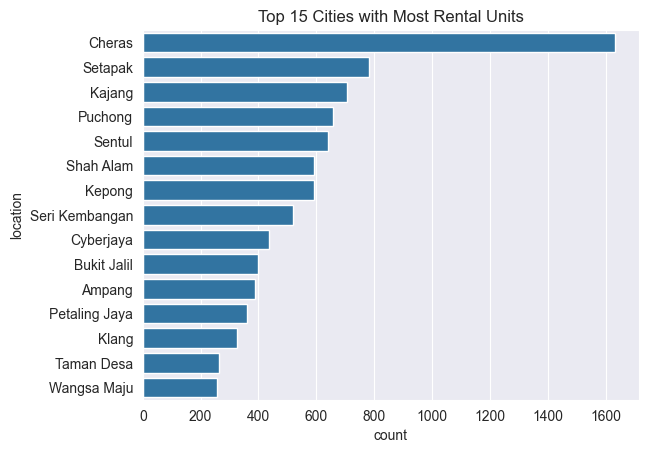

In [31]:
df['location'] = df['location'].str.split(' - ').str[1]
top_cities = df['location'].value_counts().reset_index()[:15]

# Plot bar chart
plt.title('Top 15 Cities with Most Rental Units')
sns.barplot(data=top_cities, x='count', y='location')

Let's see how property types affect the rental price

<Axes: title={'center': 'Average Monthly Rent for each Property Type'}, xlabel='monthly_rent', ylabel='property_type'>

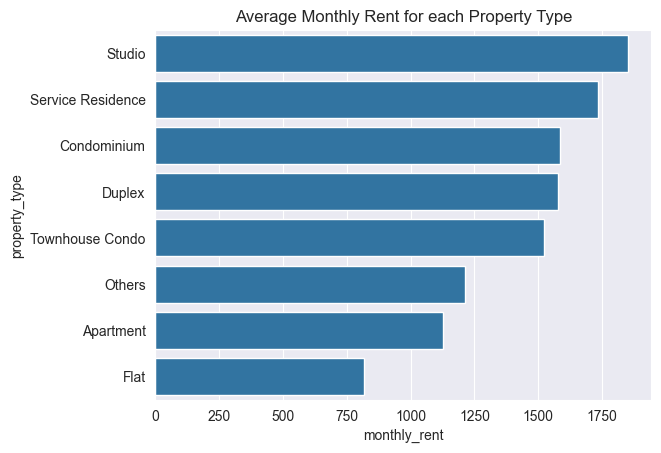

In [32]:
type_price = df.groupby(['property_type'])['monthly_rent'].mean().sort_values(ascending=False).reset_index()

# Plot bar chart
plt.title('Average Monthly Rent for each Property Type')
sns.barplot(data=type_price, x='monthly_rent', y='property_type')

<Axes: title={'center': 'Top 15 Cities with Most Expensive Price per Room'}, xlabel='price_per_room', ylabel='location'>

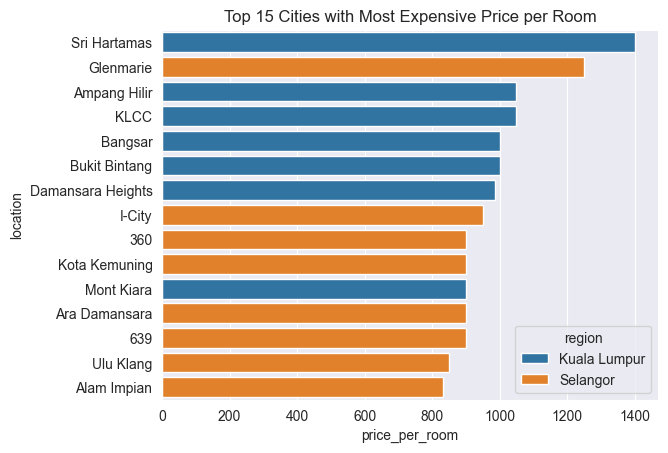

In [33]:
df2 = df.copy()
df2['price_per_room'] = df2['monthly_rent'] / df2['rooms']

# Look at only the top 15 most expensive ones
expensive_cities = df2.groupby(['location', 'region'])[['price_per_room']].median().sort_values(by='price_per_room', ascending=False)[:15]

# Plot bar chart
plt.title('Top 15 Cities with Most Expensive Price per Room')
sns.barplot(data=expensive_cities, x='price_per_room', y='location', hue='region')

<Axes: title={'center': 'Price per Room against Completion Year'}, xlabel='completion_year', ylabel='price_per_room'>

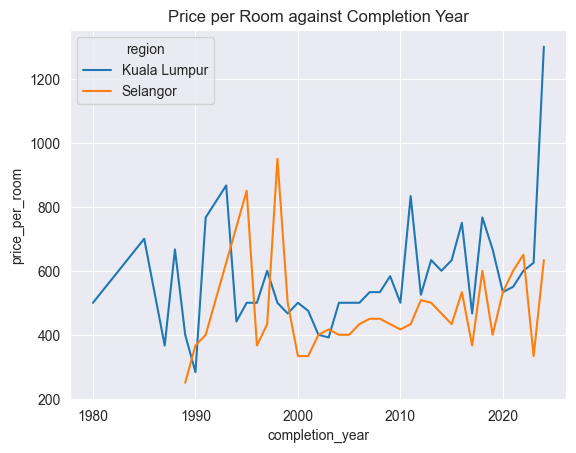

In [34]:
pricing_trend = df2.groupby(['completion_year', 'region'])[['price_per_room']].median()

# Plot line graph
plt.title('Price per Room against Completion Year')
sns.lineplot(data=pricing_trend, x='completion_year', y='price_per_room', hue='region')

<Axes: title={'center': 'Top 15 Cities with Biggest Rental Units'}, xlabel='size', ylabel='location'>

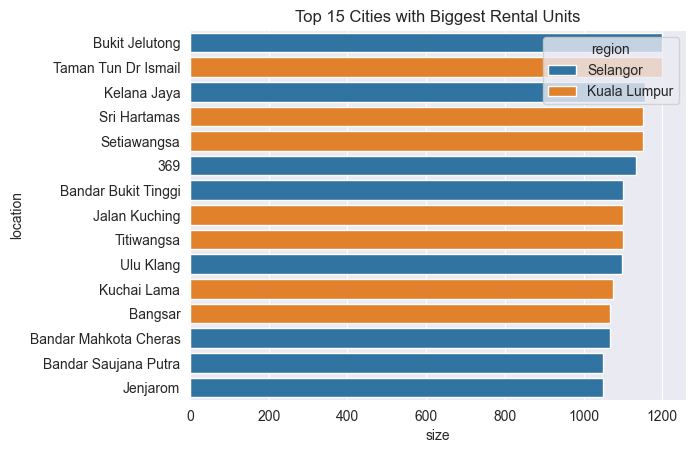

In [35]:
# Look at only the top 15 most expensive ones
expensive_cities = df2.groupby(['location', 'region'])[['size']].median().sort_values(by='size', ascending=False)[:15]

# Plot bar chart
plt.title('Top 15 Cities with Biggest Rental Units')
sns.barplot(data=expensive_cities, x='size', y='location', hue='region')

<Axes: xlabel='region'>

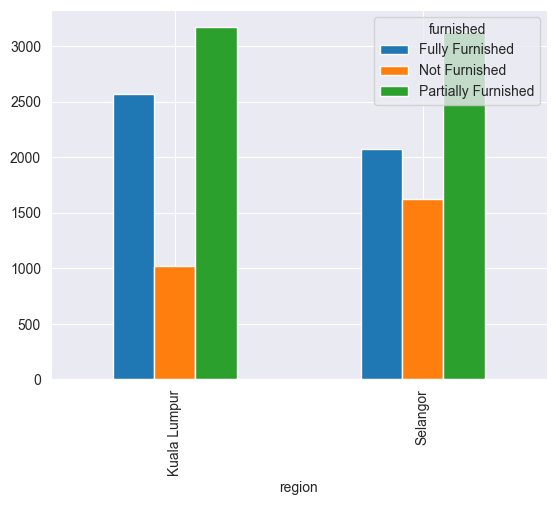

In [36]:
df.groupby(['region', 'furnished']).size().unstack(fill_value=0).plot(kind='bar')

<Axes: xlabel='region'>

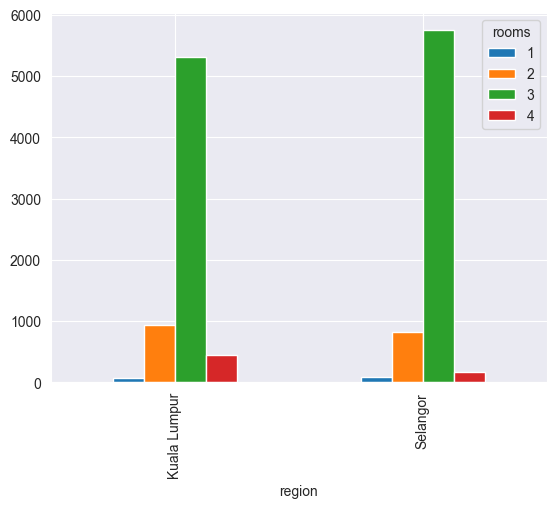

In [37]:
df.groupby(['region', 'rooms']).size().unstack(fill_value=0).plot(kind='bar')

<Axes: xlabel='region'>

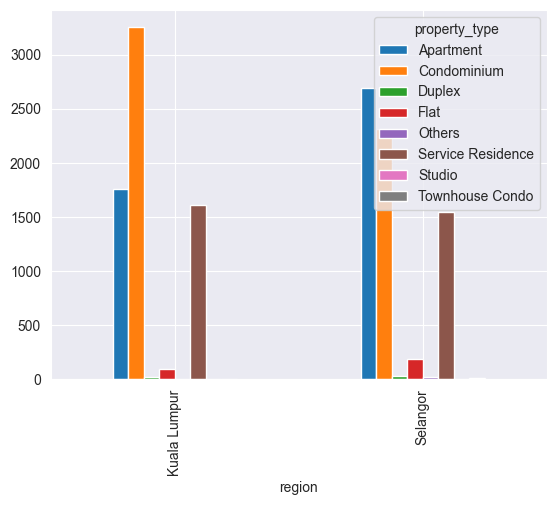

In [38]:
df.groupby(['region', 'property_type']).size().unstack(fill_value=0).plot(kind='bar')

## Feature Engineering

Since we have numerical and categorical columns in our dataset, we will need to perform encoding on the categorical ones

In [39]:
# Create mapping from property type to average price sorted
type_price_map = type_price.drop('monthly_rent', axis=1).reset_index().set_index('property_type')['index']

# Use label encoding on property type column
df['property_type'] = df['property_type'].map(type_price_map)

# Use label encoding on furnished column
df.loc[df['furnished'] == 'Not Furnished','furnished'] = 0
df.loc[df['furnished'] == 'Partially Furnished','furnished'] = 1
df.loc[df['furnished'] == 'Fully Furnished','furnished'] = 2

# Use label encoding on region column
df.loc[df['region'] == 'Selangor', 'region'] = 0
df.loc[df['region'] == 'Kuala Lumpur', 'region'] = 1

df

,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,region
1,2017,2300,Cheras,2,3,1,2,1170,1,1
2,2017,1000,Taman Desa,6,3,0,2,650,2,1
3,2020,1700,Sentul,6,2,1,2,743,1,1
5,2017,1500,Setapak,6,3,1,2,884,1,1
9,2017,1350,Desa ParkCity,2,3,1,2,862,1,1
...,...,...,...,...,...,...,...,...,...,...
19982,2017,1100,Puchong,6,3,1,2,941,1,0
19983,2021,885,Cyberjaya,2,3,2,2,1015,1,0
19986,2017,1200,Kajang,6,3,0,2,1000,1,0
19988,2017,1350,Kajang,2,3,2,2,1270,1,0


In [40]:
# Drop location since encoding is unwise, use region instead
df = df.drop('location', axis=1)
df

,completion_year,monthly_rent,property_type,rooms,parking,bathroom,size,furnished,region
1,2017,2300,2,3,1,2,1170,1,1
2,2017,1000,6,3,0,2,650,2,1
3,2020,1700,6,2,1,2,743,1,1
5,2017,1500,6,3,1,2,884,1,1
9,2017,1350,2,3,1,2,862,1,1
...,...,...,...,...,...,...,...,...,...
19982,2017,1100,6,3,1,2,941,1,0
19983,2021,885,2,3,2,2,1015,1,0
19986,2017,1200,6,3,0,2,1000,1,0
19988,2017,1350,2,3,2,2,1270,1,0


In [41]:
# "Scaling" completion_year
df['year_since_completion'] = 2024 - df['completion_year']
df = df.drop('completion_year', axis=1)
df

,monthly_rent,property_type,rooms,parking,bathroom,size,furnished,region,year_since_completion
1,2300,2,3,1,2,1170,1,1,7
2,1000,6,3,0,2,650,2,1,7
3,1700,6,2,1,2,743,1,1,4
5,1500,6,3,1,2,884,1,1,7
9,1350,2,3,1,2,862,1,1,7
...,...,...,...,...,...,...,...,...,...
19982,1100,6,3,1,2,941,1,0,7
19983,885,2,3,2,2,1015,1,0,3
19986,1200,6,3,0,2,1000,1,0,7
19988,1350,2,3,2,2,1270,1,0,7


## Model Building

### Linear Regression

In [42]:
# Prepare the data for training
standard_scaler = StandardScaler()
df['size'] = standard_scaler.fit_transform(df.loc[:, ['size']])
df['furnished'] = df['furnished'].astype(int)
df['region'] = df['region'].astype(int)
y = df['monthly_rent']
X = df.drop('monthly_rent', axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE_SEED)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (9510, 8)
X_test shape: (4076, 8)
y_train shape: (9510,)
y_test shape: (4076,)


In [43]:
# Create and train the model
linear_model = Ridge()
linear_model.fit(X_train, y_train)

y_pred_lm = linear_model.predict(X_test)

print('RMSE:', lm_rmse := np.sqrt(mean_squared_error(y_test, y_pred_lm)))
print('MAE:', lm_mae := mean_absolute_error(y_test, y_pred_lm))

RMSE: 331.73108636791756
MAE: 252.43712608523472


### Tuning Ridge Model

In [44]:
param_grid = {
    'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

tuned_linear_model = grid_search.best_estimator_
tuned_linear_model.fit(X_train, y_train)

y_pred_tuned_lm = tuned_linear_model.predict(X_test)

print(f'Best parameters: {grid_search.best_params_}')
print('RMSE:', tuned_lm_rmse := np.sqrt(mean_squared_error(y_test, y_pred_tuned_lm)))
print('MAE:', tuned_lm_mae := mean_absolute_error(y_test, y_pred_tuned_lm))

Best parameters: {'alpha': 10}
RMSE: 331.72640863634035
MAE: 252.4224451187362


## Model 2: Ensemble Model

Here we are using XGBoost Regressor model as our ensemble model to compare the prediction accuracy with the basic linear model

In [45]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print('RMSE:', xgb_rmse := np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('MAE:', xgb_mae := mean_absolute_error(y_test, y_pred_xgb))

RMSE: 264.15701210684244
MAE: 190.3484818418314


### Tuning XGBoost Regressor

In [46]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

tuned_xgb_model = grid_search.best_estimator_
tuned_xgb_model.fit(X_train, y_train)

y_pred_tuned_xgb = tuned_xgb_model.predict(X_test)

print(f'Best parameters: {grid_search.best_params_}')
print('RMSE:', tuned_xgb_rmse := np.sqrt(mean_squared_error(y_test, y_pred_tuned_xgb)))
print('MAE:', tuned_xgb_mae := mean_absolute_error(y_test, y_pred_tuned_xgb))

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
RMSE: 261.77783641732555
MAE: 186.48932519675003


# Model Results

In [47]:
# Look at the model results
pd.DataFrame({
    'Model': ['Ridge Model', 'Tuned Ridge Model', 'XGBoost Regressor', 'Tuned XGBoost Regressor'],
    'RMSE': [lm_rmse, tuned_lm_rmse, xgb_rmse, tuned_xgb_rmse],
    'MAE': [lm_mae, tuned_lm_mae, xgb_mae, tuned_xgb_mae]
})

,Model,RMSE,MAE
0,Ridge Model,331.731086,252.437126
1,Tuned Ridge Model,331.726409,252.422445
2,XGBoost Regressor,264.157012,190.348482
3,Tuned XGBoost Regressor,261.777836,186.489325
